In [13]:
#!/usr/bin/env python3

Post processing code to compare the outputs for two different models of the same galaxy. In this example it is for a windowed vs non windowed approach

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import dnest4 as dn4
from pyblobby3d import PostBlobby3D
from pyblobby3d import SpectralModel


In [15]:
# paths to the directories containing the data and output for both models
model1_path = '/Users/scol0322/Documents/processed/485885/'
model2_path = '/Users/scol0322/Documents/processed/485885-windowed/'


model_names = ['485885', '485885-windowed']
model_paths = [model1_path, model2_path]

# save current directory
original_dir = os.getcwd()

In [16]:
def read_options_file(options_file):
    """read the options file to extract emission lines and nlines."""
    lines = []
    lsf_fwhm = None
    
    with open(options_file, 'r') as f:
        for line in f:
            # skip comments and empty lines
            if line.strip().startswith('#') or not line.strip():
                continue
            
            # remove inline comments
            if '#' in line:
                line = line[:line.index('#')]
            
            parts = line.strip().split()
            if not parts:
                continue
            
            if parts[0].upper() == 'LINE':
                # parse line definition: LINE main_wavelength [coupled_wavelength1 ratio1 ...]
                line_data = []
                for i, part in enumerate(parts[1:]):
                    try:
                        line_data.append(float(part))
                    except ValueError:
                        break
                
                if line_data:
                    lines.append(line_data)
            
            elif parts[0].upper() == 'LSFFWHM':
                try:
                    lsf_fwhm = float(parts[1])
                except (ValueError, IndexError):
                    pass
    
    nlines = len(lines)
    return lines, nlines, lsf_fwhm

def read_metadata_file(metadata_file):
    """read metadata file to get resolution and calculate lsf_fwhm for each window."""
    wavelength_windows = []
    
    with open(metadata_file, 'r') as f:
        for line in f:
            # skip comments and empty lines
            if line.strip().startswith('#') or not line.strip():
                continue
            
            # remove inline comments
            if '#' in line:
                line = line[:line.index('#')]
            
            parts = line.strip().split()
            if not parts:
                continue
            
            if parts[0].upper() == 'WAVE_RANGE' and len(parts) >= 6:
                r_min = float(parts[1])
                r_max = float(parts[2])
                try:
                    # first try 7th column (index 6)
                    if len(parts) > 6:
                        lsf_fwhm = float(parts[6])
                    else:
                        lsf_fwhm = 1.5
                except (ValueError, IndexError):
                    # fallback calculation
                    lsf_fwhm = 1.5

                wavelength_windows.append({
                    'r_min': r_min,
                    'r_max': r_max,
                    'lsf_fwhm': lsf_fwhm
                })
    
    return wavelength_windows

def load_model_data(dir_path, model_name):
    """load and process data for a single model."""
    print(f"\n{'='*50}")
    print(f"Processing model: {model_name}")
    print(f"{'='*50}")
    
    # read emission lines and metadata from files
    options_file = os.path.join(dir_path, 'MODEL_OPTIONS')
    emission_lines, nlines, lsf_fwhm_global = read_options_file(options_file)
    print(f"number of emission lines detected: {nlines}")
    
    # read wavelength windows
    metadata_file = os.path.join(dir_path, 'metadata.txt')
    wavelength_windows = read_metadata_file(metadata_file)
    print(f"number of wavelength windows: {len(wavelength_windows)}")
    
    # create PostBlobby3D object
    post_b3d = PostBlobby3D(
        samples_path=dir_path+'posterior_sample.txt',
        data_path=dir_path+'data.txt',
        var_path=dir_path+'var.txt',
        metadata_path=dir_path+'metadata.txt',
        nlines=nlines)
    
    return {
        'post_b3d': post_b3d,
        'emission_lines': emission_lines,
        'nlines': nlines,
        'wavelength_windows': wavelength_windows,
        'lsf_fwhm_global': lsf_fwhm_global
    }

In [17]:
# load both models
models = {}
for i, (path, name) in enumerate(zip(model_paths, model_names)):
    models[name] = load_model_data(path, name)

# extract models for easier reference
model1 = models[model_names[0]]
model2 = models[model_names[1]]

print(f"\n{'='*60}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*60}")
print(f"{model_names[0]}: {model1['nlines']} lines, {len(model1['wavelength_windows'])} windows")
print(f"{model_names[1]}: {model2['nlines']} lines, {len(model2['wavelength_windows'])} windows")



Processing model: 485885
number of emission lines detected: 2
number of wavelength windows: 1
Loading metadata from: /Users/scol0322/Documents/processed/485885/metadata.txt
  NI: 27
  NJ: 31
  X_MIN: -7.5
  X_MAX: 8.0
  Y_MIN: -6.5
  Y_MAX: 7.0
  WAVE_RANGE: 6535.076955 - 6595.057979 Å (bins 0-106, n=107)
  Validated window 1: bins 0-106
Metadata loaded successfully.
Found 1 wavelength windows
  Window 1: [6535.076955, 6595.057979] Å (107 bins, dr=0.5606 Å/bin)
Total wavelength coverage: 6535.076955 - 6595.057979 Å
Total wavelength bins: 107
Image Loaded...
Variance Loaded...
Samples processed successfully.

Processing model: 485885-windowed
number of emission lines detected: 2
number of wavelength windows: 3
Loading metadata from: /Users/scol0322/Documents/processed/485885-windowed/metadata.txt
  NI: 27
  NJ: 31
  X_MIN: -7.5
  X_MAX: 8.0
  Y_MIN: -6.5
  Y_MAX: 7.0
  WAVE_RANGE: 6542.924939 - 6553.575775 Å (bins 0-18, n=19)
  WAVE_RANGE: 6557.499768 - 6568.150604 Å (bins 19-37, n=19)

Loading original metadata from: /Users/scol0322/Documents/processed/485885/metadata.txt
  Original dimensions: 27 x 31 x 107
  Wavelength coverage: 6535.08 - 6595.06 Å
  Number of ranges: 1
    Range 1: 6535.08 - 6595.06 Å (107 bins)
Loading data cube from: /Users/scol0322/Documents/processed/485885/data.txt
  Data cube shape: (27, 31, 107)
Loading original metadata from: /Users/scol0322/Documents/processed/485885-windowed/metadata.txt
  Original dimensions: 27 x 31 x 57
  Wavelength coverage: 6542.92 - 6588.33 Å
  Number of ranges: 3
    Range 1: 6542.92 - 6553.58 Å (19 bins)
    Range 2: 6557.50 - 6568.15 Å (19 bins)
    Range 3: 6577.68 - 6588.33 Å (19 bins)
Loading data cube from: /Users/scol0322/Documents/processed/485885-windowed/data.txt
  Data cube shape: (27, 31, 57)


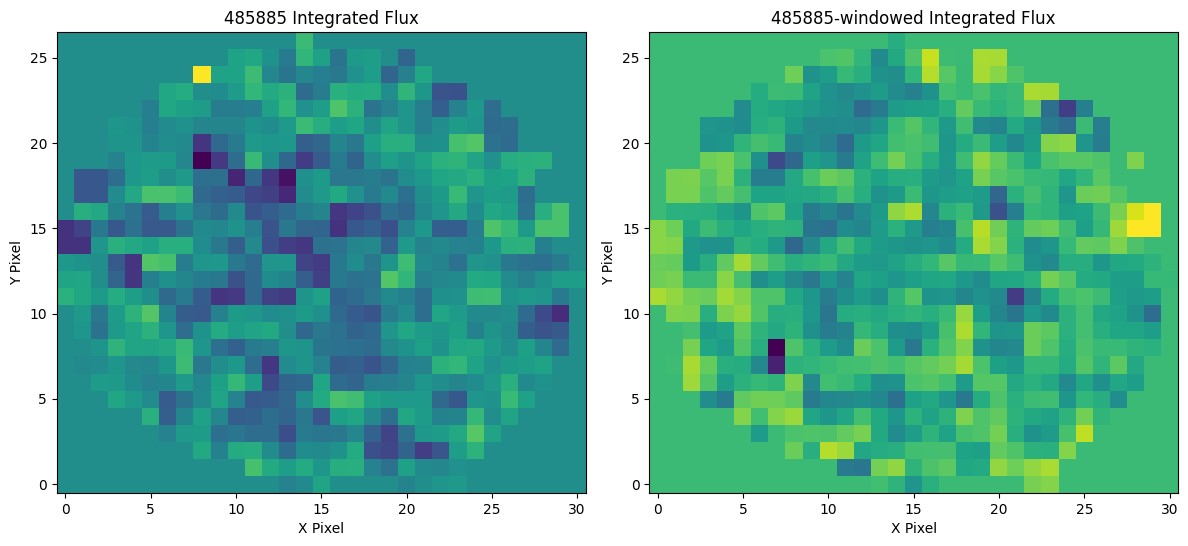

In [ ]:
# read the data files for both models

def load_original_metadata(metadata_path):
    """Load original metadata from file with new format."""
    print(f"Loading original metadata from: {metadata_path}")
    
    metadata = {}
    wavelength_ranges = []
    
    with open(metadata_path, 'r') as f:
        for line in f:
            line = line.strip()
            
            # skip empty lines and comments
            if not line or line.startswith('#'):
                continue
            
            # remove inline comments
            if '#' in line:
                line = line[:line.index('#')].strip()
            
            parts = line.split()
            if len(parts) < 2:
                continue
                
            keyword = parts[0].lower()
            
            if keyword == 'ni':
                metadata['ni'] = int(parts[1])
            elif keyword == 'nj':
                metadata['nj'] = int(parts[1])
            elif keyword == 'x_min':
                metadata['x_min'] = float(parts[1])
            elif keyword == 'x_max':
                metadata['x_max'] = float(parts[1])
            elif keyword == 'y_min':
                metadata['y_min'] = float(parts[1])
            elif keyword == 'y_max':
                metadata['y_max'] = float(parts[1])
            elif keyword == 'wave_range':
                if len(parts) >= 6:
                    wave_range = {
                        'r_min': float(parts[1]),
                        'r_max': float(parts[2]),
                        'start_col': int(parts[3]),
                        'end_col': int(parts[4]),
                        'n_bins': int(parts[5])
                    }
                    wavelength_ranges.append(wave_range)
    
    # validate required parameters
    required_keys = ['ni', 'nj', 'x_min', 'x_max', 'y_min', 'y_max']
    for key in required_keys:
        if key not in metadata:
            raise ValueError(f"Required parameter '{key}' not found in metadata file")
    
    if not wavelength_ranges:
        raise ValueError("No wavelength ranges found in metadata file")
    
    # calculate overall wavelength coverage
    metadata['r_min'] = min(wr['r_min'] for wr in wavelength_ranges)
    metadata['r_max'] = max(wr['r_max'] for wr in wavelength_ranges)
    metadata['total_bins'] = sum(wr['n_bins'] for wr in wavelength_ranges)
    metadata['wavelength_ranges'] = wavelength_ranges
    
    # create combined wavelength array
    wavelengths = []
    for wr in wavelength_ranges:
        dr = (wr['r_max'] - wr['r_min']) / wr['n_bins']
        wave_range = np.linspace(wr['r_min'] + 0.5*dr, wr['r_max'] - 0.5*dr, wr['n_bins'])
        wavelengths.extend(wave_range)
    
    metadata['wavelengths'] = np.array(wavelengths)
    metadata['dr'] = (metadata['r_max'] - metadata['r_min']) / metadata['total_bins']  # Average
    
    print(f"  Original dimensions: {metadata['ni']} x {metadata['nj']} x {metadata['total_bins']}")
    print(f"  Wavelength coverage: {metadata['r_min']:.2f} - {metadata['r_max']:.2f} Å")
    print(f"  Number of ranges: {len(wavelength_ranges)}")
    for i, wr in enumerate(wavelength_ranges):
        print(f"    Range {i+1}: {wr['r_min']:.2f} - {wr['r_max']:.2f} Å ({wr['n_bins']} bins)")
    
    return metadata

def load_data_cube(data_path, metadata):
    """Load and reshape data cube."""
    print(f"Loading data cube from: {data_path}")
    data_flat = np.loadtxt(data_path)
    
    # reshape from flat array to 3D cube (ni, nj, nr)
    expected_size = metadata['ni'] * metadata['nj'] #* metadata['total_bins']
    if len(data_flat) != expected_size:
        raise ValueError(f"Data size mismatch: expected {expected_size}, got {len(data_flat)}")
    
    data_cube = data_flat.reshape(metadata['ni'], metadata['nj'], metadata['total_bins'])
    print(f"  Data cube shape: {data_cube.shape}")
    return data_cube


metadata_1 = load_original_metadata(model1_path + 'metadata.txt')
original_data_1  = load_data_cube(model1_path + 'data.txt', metadata_1)

metadata_2 = load_original_metadata(model2_path + 'metadata.txt')
original_data_2  = load_data_cube(model2_path + 'data.txt', metadata_2)

# 1. SIDE-BY-SIDE INTEGRATED FLUX MAPS COMPARISON

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(original_data_1.sum(axis=2), origin='lower', cmap='viridis')
axes[0].set_title(f"{model_names[0]} Integrated Flux")
axes[0].set_xlabel('X Pixel')
axes[0].set_ylabel('Y Pixel')
axes[1].imshow(original_data_2.sum(axis=2), origin='lower', cmap='viridis')
axes[1].set_title(f"{model_names[1]} Integrated Flux")
axes[1].set_xlabel('X Pixel')
axes[1].set_ylabel('Y Pixel')
plt.tight_layout()
plt.show()   

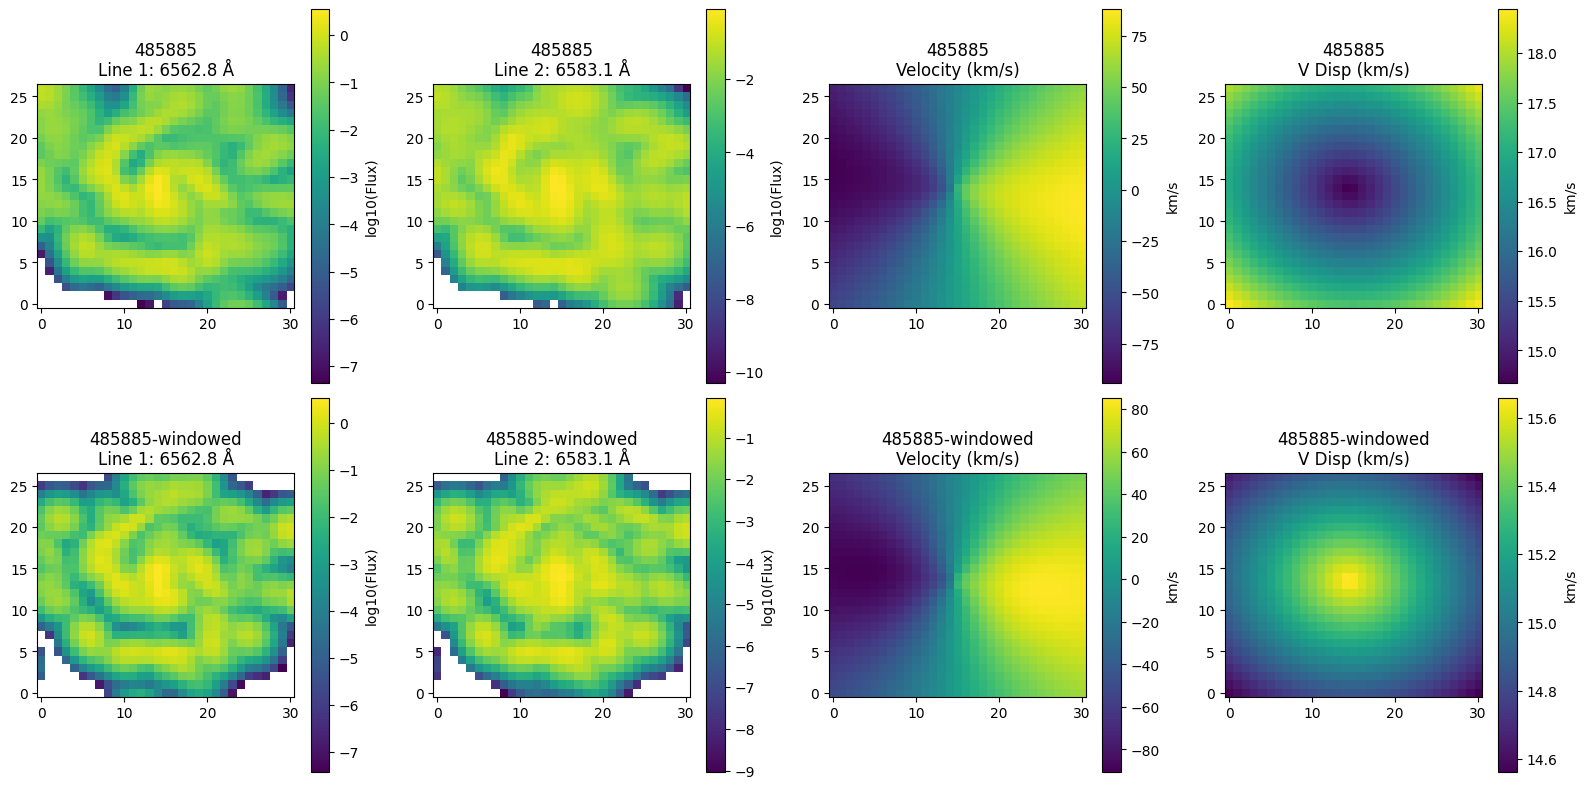

In [25]:
# choose sample for comparison
sample = 0

# 1. SIDE-BY-SIDE FLUX MAPS COMPARISON
max_lines = max(model1['nlines'], model2['nlines'])
fig, axes = plt.subplots(2, max_lines + 2, figsize=(4*(max_lines + 2), 8))

for row, (model_data, model_name) in enumerate([(model1, model_names[0]), (model2, model_names[1])]):
    nlines = model_data['nlines']
    post_b3d = model_data['post_b3d']
    
    # flux maps for each line
    for line_idx in range(max_lines):
        col = line_idx
        if line_idx < nlines:
            flux_map = post_b3d.maps[sample, line_idx]
            flux_map_safe = np.where(flux_map > 0, flux_map, np.nan)
            im = axes[row, col].imshow(np.log10(flux_map_safe), interpolation='nearest', origin='lower')
            plt.colorbar(im, ax=axes[row, col], label='log10(Flux)')
            
            # get line wavelength for title
            if line_idx < len(model_data['emission_lines']):
                main_wave = model_data['emission_lines'][line_idx][0]
                axes[row, col].set_title(f'{model_name}\nLine {line_idx+1}: {main_wave:.1f} Å')
            else:
                axes[row, col].set_title(f'{model_name}\nLine {line_idx+1}')
        else:
            axes[row, col].text(0.5, 0.5, 'N/A', ha='center', va='center', transform=axes[row, col].transAxes)
            axes[row, col].set_title(f'{model_name}\nNo Line {line_idx+1}')
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
    
    # velocity map
    col = max_lines
    im_v = axes[row, col].imshow(post_b3d.maps[sample, nlines], interpolation='nearest', origin='lower')
    axes[row, col].set_title(f'{model_name}\nVelocity (km/s)')
    plt.colorbar(im_v, ax=axes[row, col], label='km/s')
    
    # velocity dispersion map
    col = max_lines + 1
    im_vd = axes[row, col].imshow(post_b3d.maps[sample, nlines+1], interpolation='nearest', origin='lower')
    axes[row, col].set_title(f'{model_name}\nV Disp (km/s)')
    plt.colorbar(im_vd, ax=axes[row, col], label='km/s')

fig.tight_layout()
plt.show()

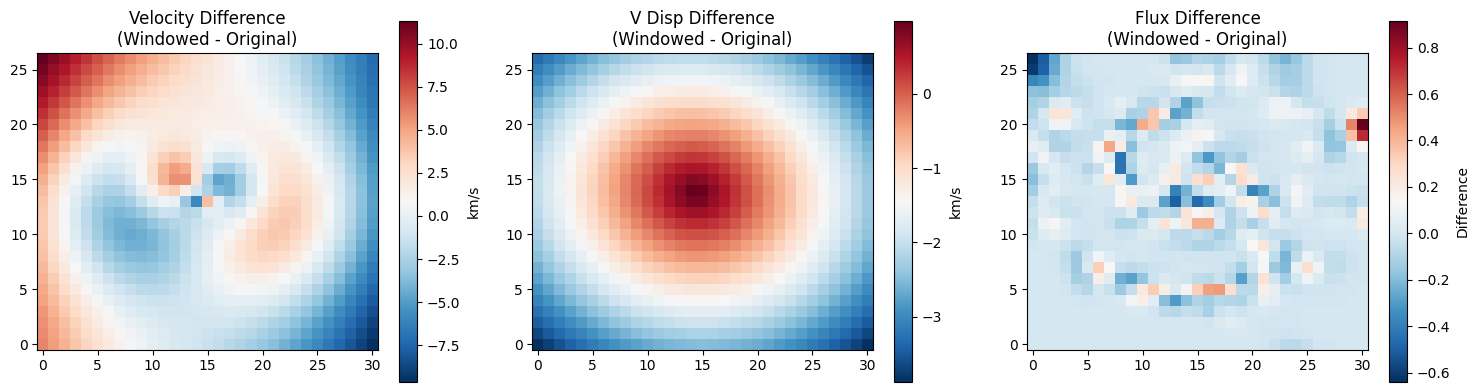

In [28]:
# 2. DIFFERENCE MAPS (MODEL2 - MODEL1)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# ensure both models have same spatial dimensions
if model1['post_b3d'].maps.shape[1:3] == model2['post_b3d'].maps.shape[1:3]:
    # velocity difference
    v_diff = model2['post_b3d'].maps[sample, model2['nlines']] - model1['post_b3d'].maps[sample, model1['nlines']]
    im1 = axes[0].imshow(v_diff, origin='lower', cmap='RdBu_r')
    axes[0].set_title('Velocity Difference\n(Windowed - Original)')
    plt.colorbar(im1, ax=axes[0], label='km/s')
    
    # velocity dispersion difference
    vd_diff = (model2['post_b3d'].maps[sample, model2['nlines']+1] - 
               model1['post_b3d'].maps[sample, model1['nlines']+1])
    im2 = axes[1].imshow(vd_diff, origin='lower', cmap='RdBu_r')
    axes[1].set_title('V Disp Difference\n(Windowed - Original)')
    plt.colorbar(im2, ax=axes[1], label='km/s')
    
    # flux difference (first line if both models have it)
    if model1['nlines'] > 0 and model2['nlines'] > 0:
        flux_diff = model2['post_b3d'].maps[sample, 0] - model1['post_b3d'].maps[sample, 0]
        # use relative difference for flux
        im3 = axes[2].imshow(flux_diff, origin='lower', cmap='RdBu_r')
        axes[2].set_title('Flux Difference\n(Windowed - Original)')
        plt.colorbar(im3, ax=axes[2], label='Difference')
    else:
        axes[2].text(0.5, 0.5, 'No flux\ncomparison\navailable', 
                     ha='center', va='center', transform=axes[2].transAxes)
        axes[2].set_title('Flux Difference (N/A)')
else:
    for ax in axes:
        ax.text(0.5, 0.5, 'different\nspatial\ndimensions', 
                ha='center', va='center', transform=ax.transAxes)

fig.tight_layout()
plt.show()

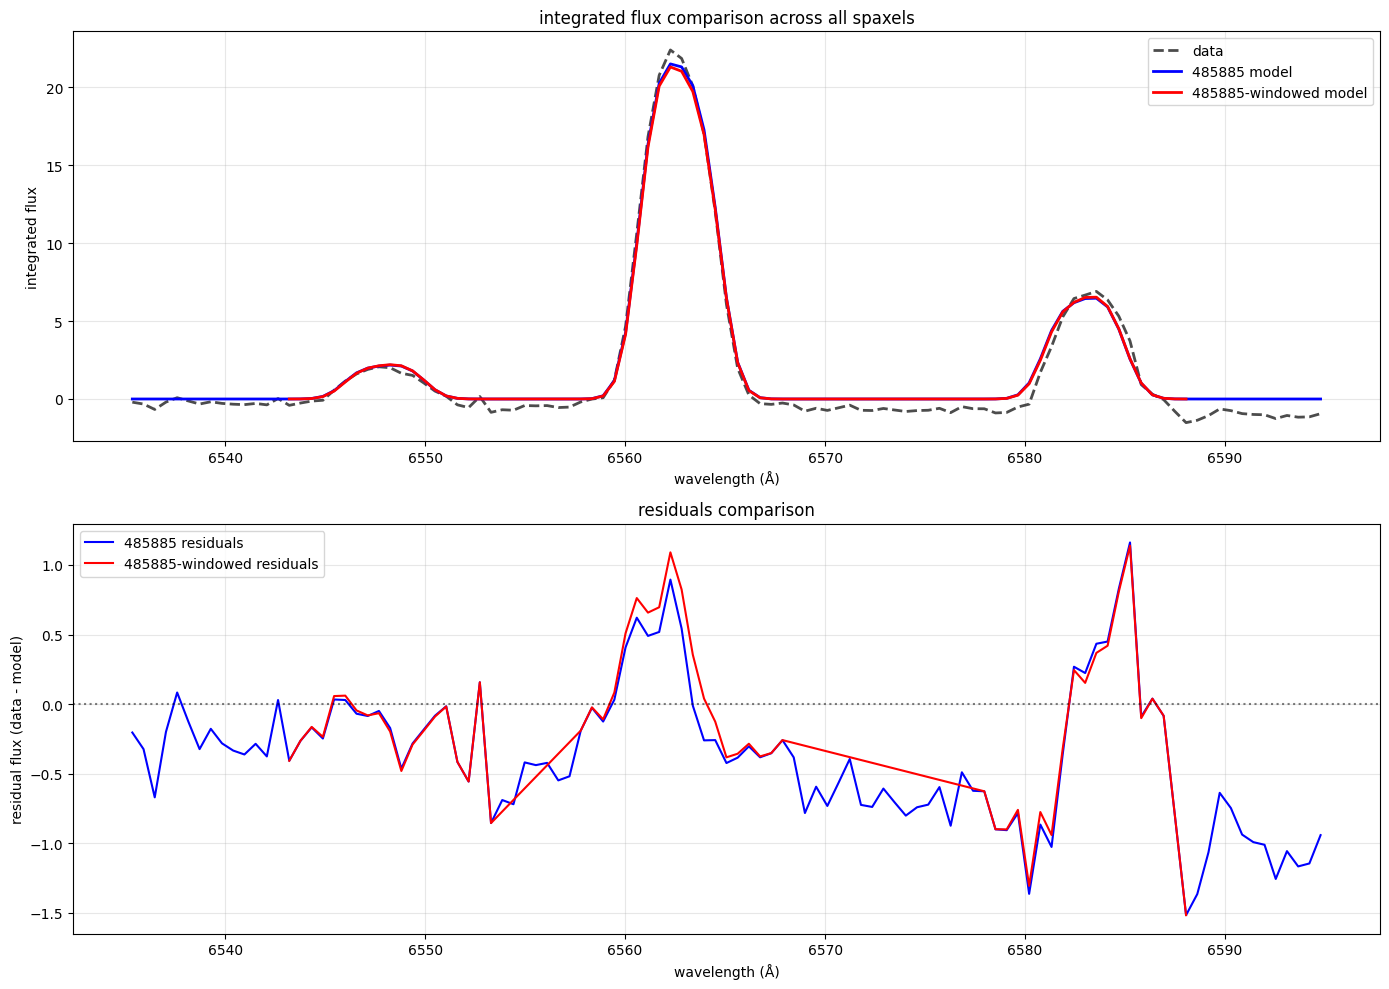

In [27]:
# 3. INTEGRATED SPECTRUM COMPARISON
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# top panel: overlaid spectra
for i, (model_data, model_name) in enumerate([(model1, model_names[0]), (model2, model_names[1])]):
    post_b3d = model_data['post_b3d']
    color = ['blue', 'red'][i]
    
    # plot data (should be same for both models)
    if i == 0:  # only plot data once
        axes[0].plot(post_b3d.metadata.r_full, post_b3d.data.sum(axis=(0, 1)), 
                    '--k', label='data', linewidth=2, alpha=0.7)
    
    # plot model
    axes[0].plot(post_b3d.metadata.r_full, post_b3d.con_cubes[sample].sum(axis=(0, 1)), 
                color=color, label=f'{model_name} model', linewidth=2)

axes[0].set_xlabel('wavelength (Å)')
axes[0].set_ylabel('integrated flux')
axes[0].set_title('integrated flux comparison across all spaxels')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# bottom panel: residuals comparison
for i, (model_data, model_name) in enumerate([(model1, model_names[0]), (model2, model_names[1])]):
    post_b3d = model_data['post_b3d']
    color = ['blue', 'red'][i]
    
    # calculate residuals
    data_integrated = post_b3d.data.sum(axis=(0, 1))
    model_integrated = post_b3d.con_cubes[sample].sum(axis=(0, 1))
    residuals = data_integrated - model_integrated
    
    axes[1].plot(post_b3d.metadata.r_full, residuals, 
                color=color, label=f'{model_name} residuals', linewidth=1.5)

axes[1].set_xlabel('wavelength (Å)')
axes[1].set_ylabel('residual flux (data - model)')
axes[1].set_title('residuals comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

creating central spaxel comparison...


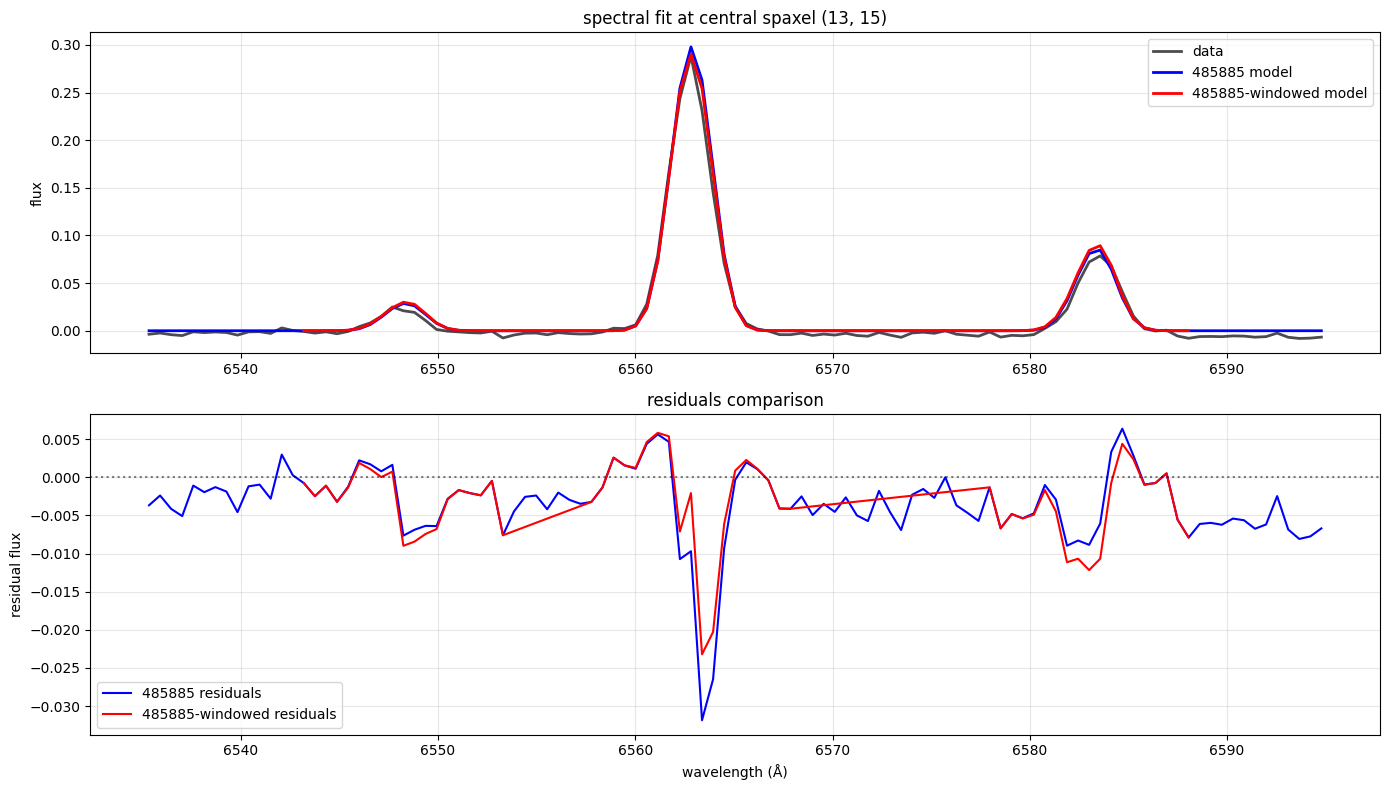

In [21]:
# 4. CENTRAL SPAXEL SPECTRAL COMPARISON
print("creating central spaxel comparison...")
central_i = model1['post_b3d'].data.shape[0] // 2
central_j = model1['post_b3d'].data.shape[1] // 2

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# plot for each model
for i, (model_data, model_name) in enumerate([(model1, model_names[0]), (model2, model_names[1])]):
    post_b3d = model_data['post_b3d']
    color = ['blue', 'red'][i]
    
    # get central spaxel spectra
    data_spectrum = post_b3d.data[central_i, central_j, :]
    model_spectrum = post_b3d.con_cubes[sample, central_i, central_j, :]
    
    # top panel: data and models
    if i == 0:  # plot data once
        axes[0].plot(post_b3d.metadata.r_full, data_spectrum, 'k-', 
                    label='data', alpha=0.7, linewidth=2)
    axes[0].plot(post_b3d.metadata.r_full, model_spectrum, color=color, 
                label=f'{model_name} model', linewidth=2)
    
    # bottom panel: residuals
    residuals = data_spectrum - model_spectrum
    axes[1].plot(post_b3d.metadata.r_full, residuals, color=color, 
                label=f'{model_name} residuals', linewidth=1.5)

axes[0].set_ylabel('flux')
axes[0].set_title(f'spectral fit at central spaxel ({central_i}, {central_j})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('wavelength (Å)')
axes[1].set_ylabel('residual flux')
axes[1].set_title('residuals comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

In [22]:
# 5. STATISTICAL COMPARISON
print("calculating statistical metrics...")
print(f"\n{'='*60}")
print("STATISTICAL COMPARISON")
print(f"{'='*60}")

for model_data, model_name in [(model1, model_names[0]), (model2, model_names[1])]:
    post_b3d = model_data['post_b3d']
    
    # calculate chi-squared and other metrics
    data_cube = post_b3d.data
    model_cube = post_b3d.con_cubes[sample]
    var_cube = post_b3d.var
    
    # mask out invalid data
    valid_mask = (var_cube > 0) & np.isfinite(data_cube) & np.isfinite(model_cube)
    
    chi_squared = np.sum(((data_cube - model_cube)**2 / var_cube)[valid_mask])
    n_data_points = np.sum(valid_mask)
    reduced_chi_squared = chi_squared / (n_data_points - post_b3d.maps.shape[-1])  # approximate dof
    
    # rms residuals
    residuals = (data_cube - model_cube)[valid_mask]
    rms_residual = np.sqrt(np.mean(residuals**2))
    
    print(f"\n{model_name}:")
    print(f"  chi-squared: {chi_squared:.2f}")
    print(f"  reduced chi-squared: {reduced_chi_squared:.3f}")
    print(f"  rms residual: {rms_residual:.4f}")
    print(f"  valid data points: {n_data_points}")


calculating statistical metrics...

STATISTICAL COMPARISON

485885:
  chi-squared: 121985.95
  reduced chi-squared: 1.854
  rms residual: 0.0028
  valid data points: 65828

485885-windowed:
  chi-squared: 73248.75
  reduced chi-squared: 2.091
  rms residual: 0.0034
  valid data points: 35067


/var/folders/b7/z1c52v893b3f3gtpw6ky62t80000gp/T/ipykernel_53361/1424659490.py:18: RuntimeWarning: divide by zero encountered in divide
  chi_squared = np.sum(((data_cube - model_cube)**2 / var_cube)[valid_mask])
/var/folders/b7/z1c52v893b3f3gtpw6ky62t80000gp/T/ipykernel_53361/1424659490.py:18: RuntimeWarning: invalid value encountered in divide
  chi_squared = np.sum(((data_cube - model_cube)**2 / var_cube)[valid_mask])



creating parameter distribution comparison...


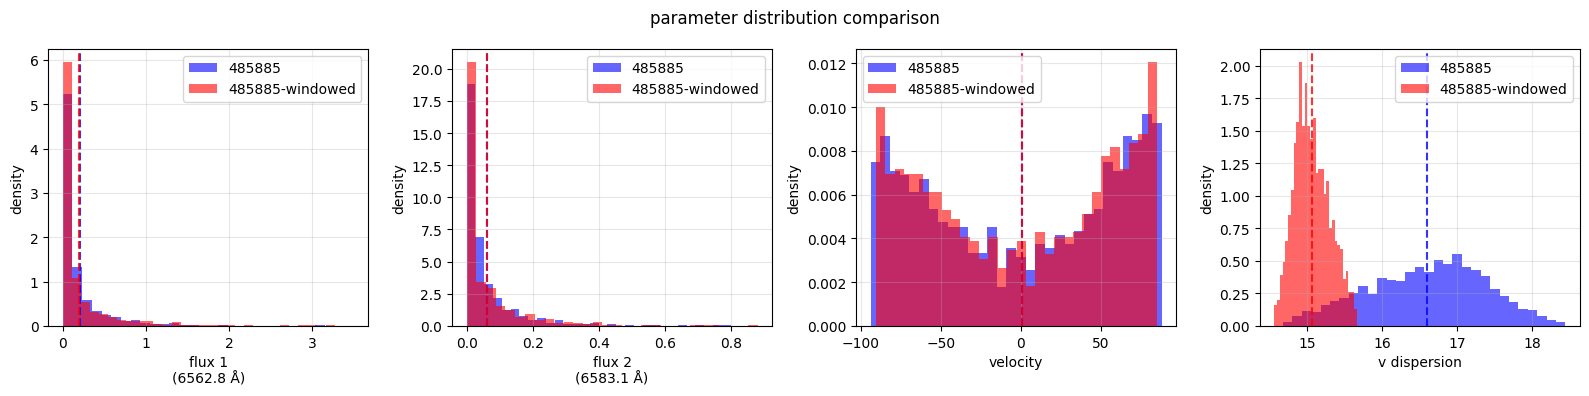


parameter statistics comparison:
parameter       model 1 mean model 1 std  model 2 mean model 2 std  difference  
---------------------------------------------------------------------------
flux 1
(6562.8 Å) 0.203        0.371        0.195        0.381        -0.008      
flux 2
(6583.1 Å) 0.062        0.100        0.061        0.107        -0.001      
velocity        0.431        60.248       0.516        58.629       0.085       
v dispersion    16.596       0.779        15.062       0.232        -1.534      


In [23]:
# 6. PARAMETER COMPARISON (if same number of lines)
if model1['nlines'] == model2['nlines']:
    print("\ncreating parameter distribution comparison...")
    
    nlines = model1['nlines']
    n_params = nlines + 2  # flux per line + velocity + velocity dispersion
    
    fig, axes = plt.subplots(1, n_params, figsize=(4*n_params, 4))
    if n_params == 1:
        axes = [axes]
    
    param_names = []
    for i in range(nlines):
        if i < len(model1['emission_lines']):
            wave = model1['emission_lines'][i][0]
            param_names.append(f'flux {i+1}\n({wave:.1f} Å)')
        else:
            param_names.append(f'flux {i+1}')
    param_names.extend(['velocity', 'v dispersion'])
    
    for p in range(n_params):
        # get parameter maps for both models
        param1 = model1['post_b3d'].maps[sample, p].flatten()
        param2 = model2['post_b3d'].maps[sample, p].flatten()
        
        # remove invalid values
        valid1 = np.isfinite(param1)
        valid2 = np.isfinite(param2)
        
        # create histograms
        axes[p].hist(param1[valid1], bins=30, alpha=0.6, label=model_names[0], 
                    color='blue', density=True)
        axes[p].hist(param2[valid2], bins=30, alpha=0.6, label=model_names[1], 
                    color='red', density=True)
        
        axes[p].set_xlabel(param_names[p])
        axes[p].set_ylabel('density')
        axes[p].legend()
        axes[p].grid(True, alpha=0.3)
        
        # add statistics
        mean1, std1 = np.mean(param1[valid1]), np.std(param1[valid1])
        mean2, std2 = np.mean(param2[valid2]), np.std(param2[valid2])
        axes[p].axvline(mean1, color='blue', linestyle='--', alpha=0.8)
        axes[p].axvline(mean2, color='red', linestyle='--', alpha=0.8)
    
    fig.suptitle('parameter distribution comparison')
    fig.tight_layout()
    plt.show()
    
    # print parameter statistics
    print(f"\nparameter statistics comparison:")
    print(f"{'parameter':<15} {'model 1 mean':<12} {'model 1 std':<12} {'model 2 mean':<12} {'model 2 std':<12} {'difference':<12}")
    print("-" * 75)
    
    for p in range(n_params):
        param1 = model1['post_b3d'].maps[sample, p].flatten()
        param2 = model2['post_b3d'].maps[sample, p].flatten()
        
        valid1 = np.isfinite(param1)
        valid2 = np.isfinite(param2)
        
        if np.sum(valid1) > 0 and np.sum(valid2) > 0:
            mean1, std1 = np.mean(param1[valid1]), np.std(param1[valid1])
            mean2, std2 = np.mean(param2[valid2]), np.std(param2[valid2])
            diff = mean2 - mean1
            
            print(f"{param_names[p]:<15} {mean1:<12.3f} {std1:<12.3f} {mean2:<12.3f} {std2:<12.3f} {diff:<12.3f}")

else:
    print(f"\nskipping parameter comparison - different number of lines ({model1['nlines']} vs {model2['nlines']})")



creating wavelength coverage comparison...


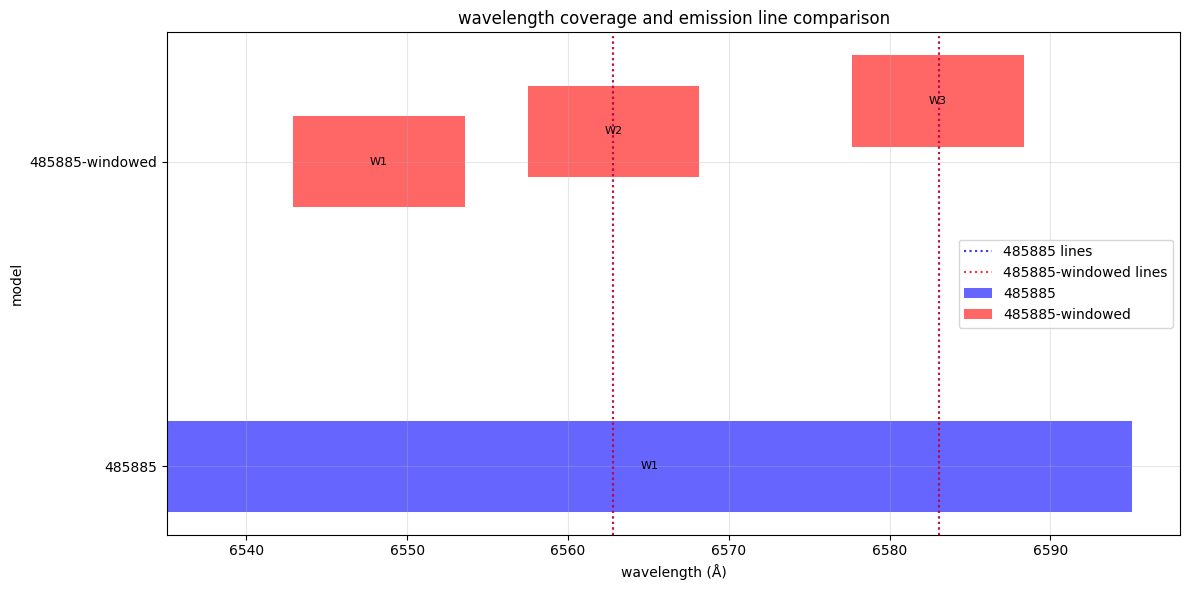

In [24]:
# 7. WAVELENGTH COVERAGE COMPARISON
print("\ncreating wavelength coverage comparison...")
fig, ax = plt.subplots(figsize=(12, 6))

for i, (model_data, model_name) in enumerate([(model1, model_names[0]), (model2, model_names[1])]):
    windows = model_data['wavelength_windows']
    color = ['blue', 'red'][i]
    
    # plot wavelength ranges
    for w, window in enumerate(windows):
        y_pos = i + 0.1 * w  # offset multiple windows slightly
        ax.barh(y_pos, window['r_max'] - window['r_min'], 
               left=window['r_min'], height=0.3, 
               color=color, alpha=0.6, 
               label=f'{model_name}' if w == 0 else None)
        
        # add window labels
        ax.text(window['r_min'] + (window['r_max'] - window['r_min'])/2, 
               y_pos, f'W{w+1}', ha='center', va='center', fontsize=8)
    
    # plot emission lines
    for line_idx, line in enumerate(model_data['emission_lines']):
        main_wave = line[0]
        ax.axvline(main_wave, color=color, linestyle=':', alpha=0.8, 
                  label=f'{model_name} lines' if line_idx == 0 else None)

ax.set_xlabel('wavelength (Å)')
ax.set_ylabel('model')
ax.set_yticks([0, 1])
ax.set_yticklabels(model_names)
ax.set_title('wavelength coverage and emission line comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()